# Question 1


## Imports


In [18]:
%pip install scikeras

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cd "/content/drive/MyDrive/ML/HW3"

In [19]:
from tensorflow.keras import datasets, layers, models
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.datasets import cifar10
import numpy as np
from keras.callbacks import EarlyStopping

In [20]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
print("[INFO] loading CIFAR-10 data...")
((trainX_full, trainY_full), (testX_full, testY_full)) = cifar10.load_data()
trainX_full = trainX_full.astype("float") / 255.0
testX = testX_full.astype("float") / 255.0
testY = testY_full

trainX, valX, trainY, valY = train_test_split(trainX_full, trainY_full, test_size=0.2, random_state=42)

# trainX = trainX.reshape((trainX.shape[0], 3072))
# testX = testX.reshape((testX.shape[0], 3072))

[INFO] loading CIFAR-10 data...


In [21]:
trainX_gray = rgb2gray(trainX)
testX_gray = rgb2gray(testX)
valX_gray = rgb2gray(valX)


## Part A


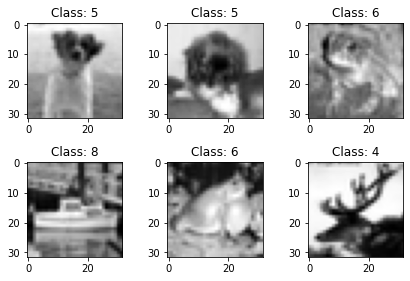

In [22]:
# Visualizing images from dataset
num_samples = 6
random_indices = np.random.choice(len(trainX), num_samples, replace=False)

for i, index in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(trainX_gray[index], cmap='gray')
    plt.title(f"Class: {trainY[index][0]}")

plt.tight_layout()
plt.show()

## Part B


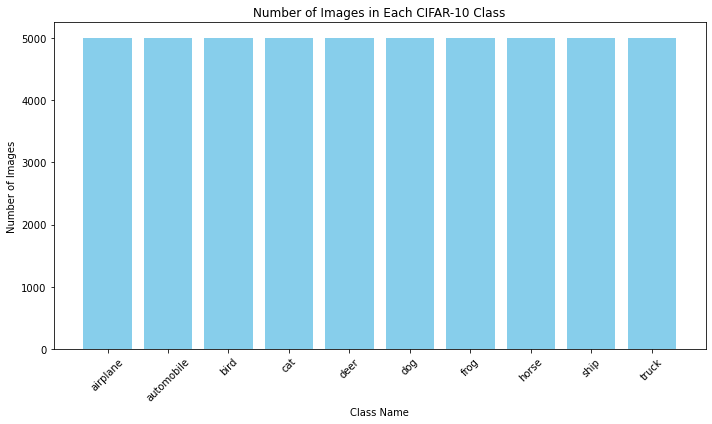

In [23]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to count the number of images in each class
class_counts = {}
for i in range(10):
    class_counts[class_names[i]] = len(trainY_full[trainY_full == i])

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each CIFAR-10 Class')
plt.xticks(rotation=45)
plt.tight_layout()

## Part C


### part i

In [24]:
print(trainX.shape)
print(testX.shape)
print(valX.shape)

# Convert trainX to grayscale

trainX = trainX_gray.reshape((trainX_gray.shape[0], -1))

# Convert testX to grayscale
testX = testX_gray.reshape((testX_gray.shape[0], -1))

valX = valX_gray.reshape((valX_gray.shape[0],-1))

print(trainX.shape)
print(testX.shape)
print(valX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1024)
(10000, 1024)
(10000, 1024)


In [25]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
valY = lb.transform(valY)
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

In [26]:
# define the 3072-1024-512-10 architecture using Keras
def build_model(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

In [ ]:
model2 = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25,nodes_per_layer=1024)

# Define hyperparameters for random search
param_dist = {
    'optimizer': [Adam(lr=0.001), SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3,0.2],
    # 'activation_function': ["relu"],
    'nodes_per_layer': [1024,512]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# time_callback_2 = TimeHistory()
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=2, cv=5)
random_result = random_search.fit(trainX, trainY,validation_data=(valX, valY), callbacks=[early_stopping])

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### part ii

In [ ]:
model = build_model(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024)

In [ ]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=50, batch_size=32)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

model.summary()

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Make predictions on the test set
y_pred = predictions
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

print(y_pred_classes.shape)
print(y_true.shape)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()

## Part D


### part i

In [ ]:
train_images, test_images = trainX_full / 255.0, testX_full / 255.0
train_images, val_images, train_labels, val_labels = train_test_split(train_images, trainY_full, test_size=0.2, random_state=42)

train_labels = to_categorical(trainY_full)
test_labels = to_categorical(testY_full)
val_labels  = to_categorical(val_labels)

print(train_images.shape)
print(val_images.shape)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels  = to_categorical(val_labels)

print(train_images.shape)
print(val_images.shape)

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(val_images, val_labels), verbose=1)
  return model

In [ ]:
model2 = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25)

# Define hyperparameters for random search
param_dist = {
    'optimizer': ['adam', SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3, 0.5,0.2]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=2, cv=2)
random_result = random_search.fit(train_images, train_labels,validation_data=(val_images, val_labels), callbacks=[early_stopping])

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### part ii

In [ ]:
model = create_model(optimizer='adam', dropout_rate=0.25)

history = model.fit(train_images, train_labels, epochs=30, validation_data=(val_images, val_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

## Part E

## Part F

In [ ]:
from keras.applications import EfficientNetB0

# Load CIFAR-10 data
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model and add the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on CIFAR-10 data
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Question 2

## Imports

In [27]:
# import the necessary packages
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("datasets/Admission.csv")
print(df.columns)

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')


## Part A

In [29]:
mean_chance_of_admit = df["Chance of Admit "].mean()
print(mean_chance_of_admit)
df["Admission"] = (df["Chance of Admit "] > mean_chance_of_admit).astype(int)
print(df["Admission"])

0.72435
0      1
1      1
2      0
3      1
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Admission, Length: 400, dtype: int64


## Part B

In [30]:
svm_linear = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
linear_svc =  make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
svm_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='rbf'))
svm_poly = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='poly'))

## Part C

In [31]:
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

for features in feature_combinations:
    X = df[features]
    y = df["Admission"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM models with the selected features
    svm_linear.fit(X_train, y_train)
    linear_svc.fit(X_train, y_train)
    svm_rbf.fit(X_train, y_train)
    svm_poly.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    plt.figure(figsize=(8, 6))
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

# List of SVM models
svm_models = [svm_linear, linear_svc, svm_rbf, svm_poly]

# List of feature combinations
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

# Visualize decision boundaries for each model and feature combination
for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]

        plt.figure(figsize=(8, 6))
        plot_decision_boundary(model, X, y, f"Model {i+1} with Features {features}")


## Part D

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465:

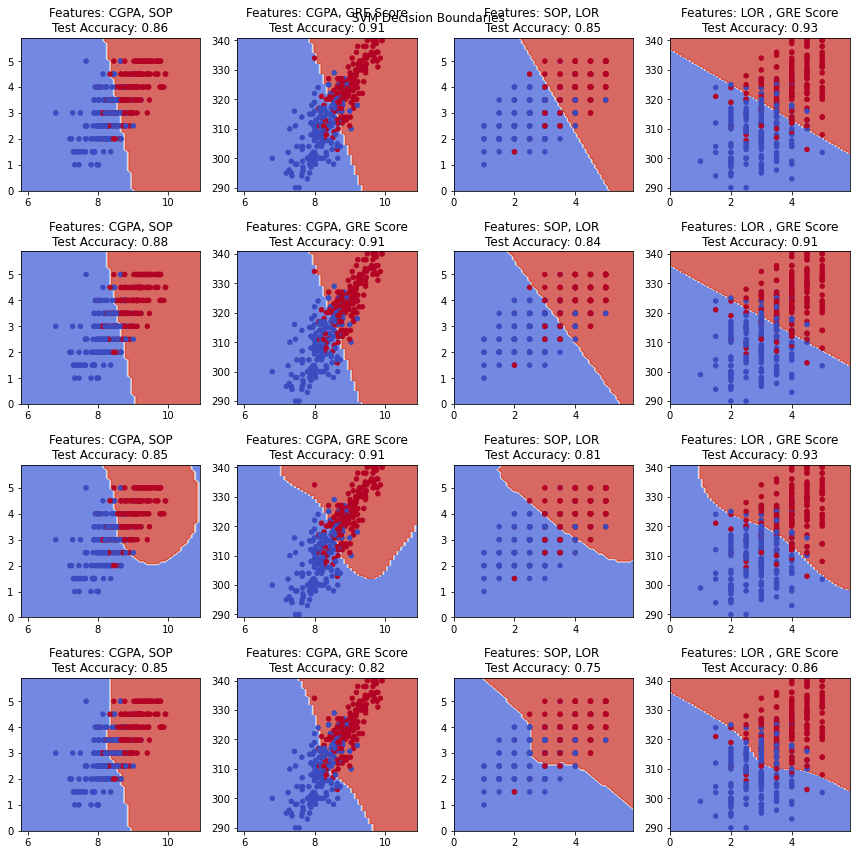

In [33]:
# Initialize subplots for visualization
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("SVM Decision Boundaries")

for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_subset = X_train
        X_test_subset = X_test

        # # Standardize the data for SVM
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train_subset)
        # X_test_scaled = scaler.transform(X_test_subset)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model on the test set
        test_accuracy = model.score(X_test, y_test)

        # Visualize the decision boundary
        ax = axes[i, j]
        x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
        y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20)
        ax.set_title(f"Features: {', '.join(features)}\nTest Accuracy: {test_accuracy:.2f}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## Part E

## Part F